In [37]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [38]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from scipy.stats import norm

from core import multi_evaluate, exp_aggregator, IdentityConv2d
import matplotlib.pyplot as plt
import numpy as np

In [39]:
# CONFIG
batch_size = 20
num_neurons = 200
data_path = 'data/imagenet'

transforms = Compose([
    Resize(size=256),
    CenterCrop(size=(224, 224)),
    ToTensor()
])


base_dataset = torchvision.datasets.ImageNet(
    root=data_path, split="val", transform=transforms
)

val_loader = DataLoader(base_dataset, batch_size=batch_size, shuffle=True)

In [40]:
def plot20(batch, name="", denormalize=False, mean=None, std=None):
    fig, axs = plt.subplots(4, 5, figsize=(11.5, 9))
    fig.subplots_adjust(hspace=0.1, wspace=0)
    
    img_idx = 0
    for i in range(4):
        for j in range(5):
            axs[i, j].axis('off')  
            
            # Undo normalization
            img = batch[img_idx].permute(1, 2, 0).cpu().numpy()  # Convert from CHW to HWC format and to numpy array
            if denormalize:
                img = (img * np.array(std)) + np.array(mean)  # Apply inverse normalization
            img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
            
            axs[i, j].imshow(img)
            img_idx += 1
    
    plt.axis('off')
    plt.suptitle(name)
    
    plt.show()

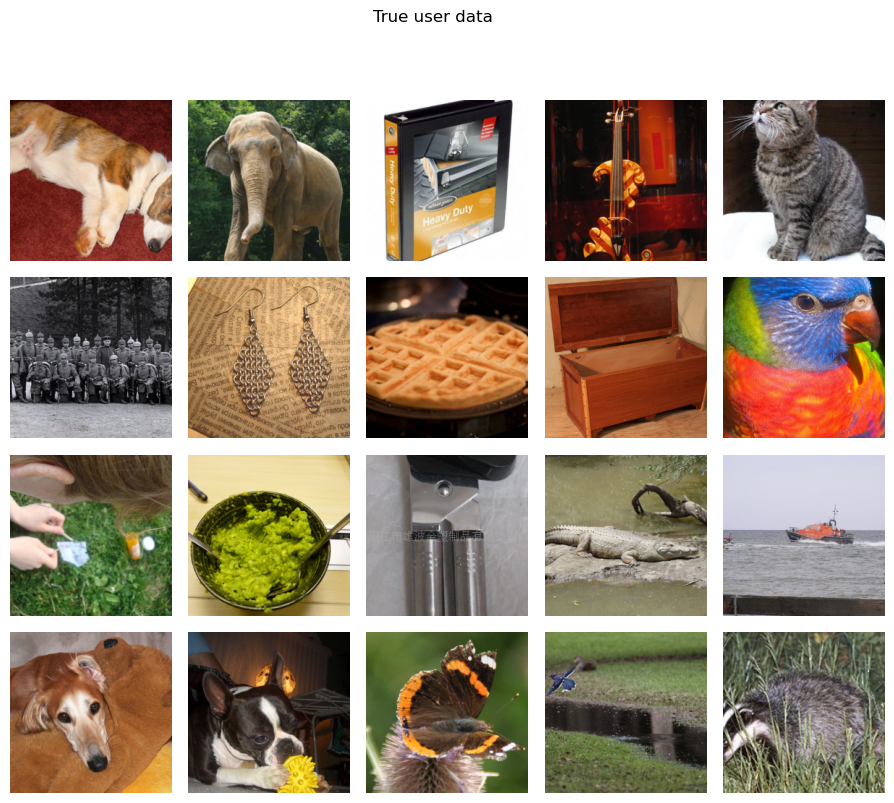

In [41]:
user_data, label = next(iter(val_loader))
plot20(user_data, "True user data")

In [42]:
device = torch.device("cpu")
layer = nn.Linear(3 * 224 * 224, num_neurons).to(device)
relu = nn.ReLU()
bn = nn.BatchNorm2d(3)

with torch.no_grad():
    layer.weight.data.normal_()
    
# QBI
optimal_bias = norm.ppf(1 / batch_size) * np.sqrt(3 * 224 * 224)
layer.bias.data.fill_(optimal_bias)

x = bn(user_data)

# Obtain batch statistics from running mean and running var
mean = bn.running_mean.numpy() / bn.momentum
std = np.sqrt((bn.running_var.numpy() - (1-bn.momentum)) / bn.momentum + bn.eps)

x = x.flatten(start_dim=1)
x = layer(x)
x = relu(x)
loss = x.mean()
loss.backward()

w_grad = layer.weight.grad.clone()
b_grad = layer.bias.grad.clone()

# reconstruct samples
intermediate = w_grad / b_grad.view(-1, 1)
intermediate = intermediate.reshape(-1, 3, 224, 224).to("cpu")

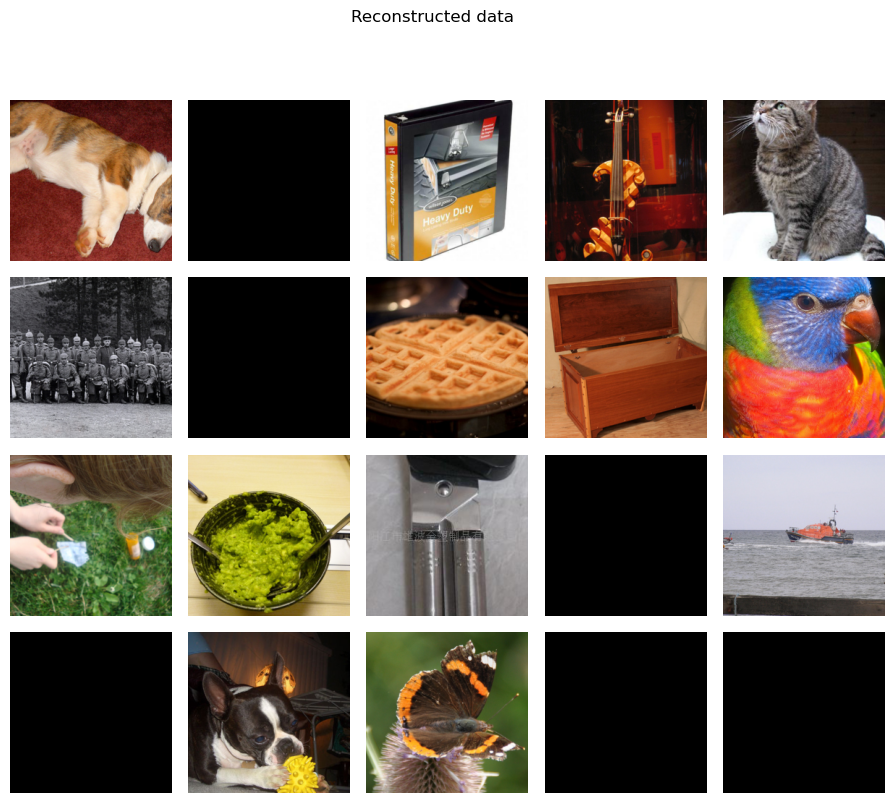

Reconstructed [14/20] images with a loss < 1e-10.


In [43]:
result = [torch.zeros_like(user_data[0]) for _ in range(20)]
reconstructed = 0
for i, user_image in enumerate(user_data):
    for n_grad in intermediate:
        # denormalize reconstructed sample
        n_grad = n_grad * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        # allow for difference < 1e-10 due to numerical inaccuracy introduced with batch computation 
        # see https://pytorch.org/docs/stable/notes/numerical_accuracy.html#batched-computations-or-slice-computations
        if torch.mean((user_image-n_grad)**2) < 1e-10:
            reconstructed += 1
            result[i] = n_grad
            break
plot20(result, "Reconstructed data", denormalize=False)
print(f"Reconstructed [{reconstructed}/20] images with a loss < 1e-10.")